# install required libraries

## NOTE: This environment has been installed basic libraries like as torch, jupyter, pandas, numpy, and so on. 

In [1]:
!pip3 install opendatasets transformers pandas-profiling -q

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# load data files

In [1]:
import pandas as pd
import numpy as np
import torch

sample_df = pd.read_csv('sample_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

sample_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [2]:
torch.manual_seed(42)

# preprocess

In [3]:
from transformers import BertForSequenceClassification, BertTokenizer, BertModel

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
train_sentences = train_df['text'].values
train_labels = train_df['target'].values
test_sentences = test_df['text'].values

In [6]:
!pip3 install nltk

In [7]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk import word_tokenize          
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/charles/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/charles/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import re

def cleaning_sentences(text, invalid_pattern='[^a-zA-Z0-9]|http://t.co/[0-9a-zA-Z]+'):
    cleaned_text = re.sub(invalid_pattern, ' ', text.lower())
    
    tokens = word_tokenize(cleaned_text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

In [10]:
train_sentences = [cleaning_sentences(sentence) for sentence in train_sentences]
test_sentences = [cleaning_sentences(sentence) for sentence in test_sentences]

## show frequency of each sentence

(array([ 157.,  557.,  992., 1220., 1383., 1522., 1088.,  545.,  131.,
          18.]),
 array([  3. ,  16.4,  29.8,  43.2,  56.6,  70. ,  83.4,  96.8, 110.2,
        123.6, 137. ]),
 <BarContainer object of 10 artists>)

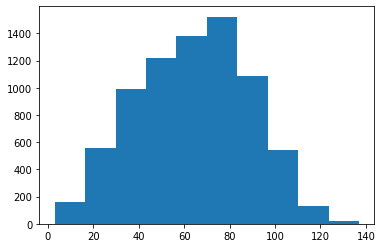

In [72]:
import matplotlib.pyplot as plt

plt.hist([len(sentence) for sentence in train_sentences])

(array([ 44., 191., 333., 446., 555., 634., 573., 355., 121.,  11.]),
 array([  0. ,  13.1,  26.2,  39.3,  52.4,  65.5,  78.6,  91.7, 104.8,
        117.9, 131. ]),
 <BarContainer object of 10 artists>)

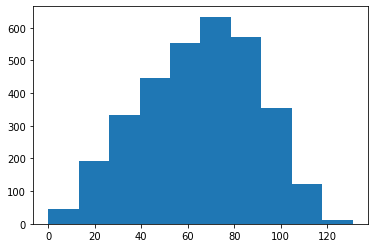

In [73]:
plt.hist([len(sentence) for sentence in test_sentences])

# tokenize

In [74]:
max_length = max([len(sentence) for sentence in np.concatenate([train_sentences, test_sentences], axis=0)])

In [75]:
def encode_sentences(sentences, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encode_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encode_dict['input_ids'])
        attention_masks.append(encode_dict['attention_mask'])
        
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [76]:
train_input_ids, train_attention_masks = encode_sentences(train_sentences, max_length)

In [77]:
train_labels = torch.tensor(train_labels)

/Users/charles/.pyenv/versions/3.7.9/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


# K-fold

In [13]:
from sklearn.model_selection import KFold

In [14]:
kfold = KFold(n_splits=5, shuffle=True)

# Train

In [15]:
from transformers import BertPreTrainedModel

class CustomBert(BertPreTrainedModel):
    def __init__(self, config):
        config.output_hidden_states = True
        super(CustomBert, self).__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(p=0.2)
        self.high_dropout = nn.Dropout(p=0.5)

        n_weights = config.num_hidden_layers + 1
        weights_init = torch.zeros(n_weights).float()
        weights_init.data[:-1] = -3
        self.layer_weights = torch.nn.Parameter(weights_init)

        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        hidden_layers = outputs[2]

        cls_outputs = torch.stack(
            [self.dropout(layer[:, 0, :]) for layer in hidden_layers], dim=2
        )
        cls_output = (torch.softmax(self.layer_weights, dim=0) * cls_outputs).sum(-1)

        # multisample dropout (wut): https://arxiv.org/abs/1905.09788
        logits = torch.mean(
            torch.stack(
                [self.classifier(self.high_dropout(cls_output)) for _ in range(5)],
                dim=0,
            ),
            dim=0,
        )

        outputs = logits
        return outputs

In [16]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

In [45]:
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, SubsetRandomSampler
from transformers import AdamW, get_linear_schedule_with_warmup

models = []

for fold, (train_dataset_ids, val_dataset_ids) in enumerate(kfold.split(dataset)):
    ## set dataset and dataloader for train
    batch_size = 16
    
    train_subsampler = SubsetRandomSampler(train_dataset_ids)
    val_subsampler = SubsetRandomSampler(val_dataset_ids)

    train_dataloader = DataLoader(dataset,
                                  sampler=train_subsampler,
                                  batch_size=batch_size)
    val_dataloader = DataLoader(dataset,
                                sampler=val_subsampler,
                                batch_size=batch_size)

    # set pretrained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomBert.from_pretrained('bert-base-uncased', num_labels=2)
    model.to(device)

    # set optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # set learning rate scheduler
    epochs = 1
    total_step = len(train_dataset_ids) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_step
    )

    def get_accuracy(preds, labels):
        preds_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(preds_flat == labels_flat) / len(preds_flat)

    # fine-tuning model

    creterion = nn.CrossEntropyLoss()
    current_val_loss = 0.0

    for epoch in range(epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0
        total_val_accuracy = 0.0

        for step, batch in enumerate(train_dataloader, 1):
            input_ids, attention_mask, labels = tuple(el.to(device) for el in batch)

            model.zero_grad()

            output = model(input_ids,
                           token_type_ids=None,
                           attention_mask=attention_mask)

            loss = creterion(output, labels)
            total_train_loss += loss

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        print(f'Train loss: {total_train_loss / len(train_dataloader)}')

        for batch in val_dataloader:
            input_ids, attention_mask, labels = tuple(el.to(device) for el in batch)

            with torch.no_grad():
                output = model(input_ids,
                               token_type_ids=None,
                               attention_mask=attention_mask)

                loss = creterion(output, labels)
                total_val_loss += loss


            logits = output.detach().cpu().numpy()
            label_ids = labels.detach().cpu().numpy()

            total_val_accuracy += get_accuracy(logits, label_ids)

        val_loss = total_val_loss / len(val_dataloader)
        print(f'Validation loss: {val_loss}')
        print(f'Validation accuracy: {total_val_accuracy / len(val_dataloader)}')

        if epoch == 0:
            current_val_loss = val_loss
        else:
            if current_val_loss <= val_loss:
                print(f'Early stop: {epoch} epoch')
                break
                
    models.append(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not SequenceClassifierOutput

# Test

In [32]:
from functools import reduce

In [33]:
test_input_ids, test_attention_masks = encode_sentences(test_sentences, max_length)

In [34]:
test_labels = torch.tensor(np.ones(len(test_input_ids)))

In [35]:
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

In [36]:
predictions = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = tuple(el.to(device) for el in batch)

    with torch.no_grad():
        models_logits = []
        
        for model in models:
            output = model(input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=None)

            logits = output.detach().cpu().numpy()
            models_logits.append(logits)
        
        sum_logits = reduce(lambda x,y: x + y, models_logits)
        pred_flatten = np.argmax(sum_logits, axis=1).flatten()

    predictions.extend(pred_flatten)

# calculate accuracy

In [37]:
correct_df = pd.read_csv('submission.csv')

In [38]:
correct_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [39]:
correct_df[correct_df['target'].values == predictions].shape[0] / correct_df.shape[0]

0.8504443763407907